<a href="https://colab.research.google.com/github/aobo-y/uva-ml/blob/master/AMTFL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Asymmetric Multi-task Feature Learning （AMTFL）

Reproduced By: Aobo Yang, Yujia Mu, David Yao, Qi Liu

Part of the following codes are from https://github.com/haebeom-lee/amtfl

**Import modules**

In [1]:
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

**Utilities**

Create utilities to help logging & storing training results

In [0]:
def log(*args):
  time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
  print(f'{time}   ', *args)

# shuffle any number of lists in same random order
def shuffle(target, *args):
  perm = np.random.permutation(len(target))
  target = target[perm]

  if args:
    args = [arg[perm] for arg in args]
    return [target, *args]
  
  return target

class Accumulator():
  def __init__(self, *args):
    self.args = args
    self.argdict = {}
    for i, arg in enumerate(args):
      self.argdict[arg] = i

    self.results = [[] for _ in args]

  def accum(self, val):
    val = [val] if type(val) is not list else val
    val = [v for v in val if v is not None]
    assert(len(val) == len(self.args))
    
    for v, res in zip(val, self.results):
      res.append(v)
      
  def clear(self):
    self.results = [[] for _ in self.args]

  # reduce: method of reducing values ['avg', 'sum']
  def get(self, arg, reduce='avg'):
    if arg in self.argdict:
      idx = self.argdict[arg]
      res = self.results[idx]
      return np.mean(res) if reduce == 'avg' else np.sum(res)
    
    return None

  def __str__(self):
    return ', '.join(f'{arg}: {self.get(arg)}' for arg in self.args)


**Data preprocessing**


Create an MNIST dataset whose tasks are imbalanced. Each number is treated as an independent task. As this work is about asymetric learning among tasks with different reliabilities, it requires to manually craft relatively unreliable tasks.

In [3]:
def grp_mnist(x_data, y_data):
  # group data by label
  x_grp = [x_data[y_data==i] for i in range(10)]
  y_grp = [y_data[y_data==i] for i in range(10)]

  return x_grp, y_grp

def onehoc_mnist_label(y_labels):
  y_data = [[0] * 10 for _ in range(y_labels.shape[0])]
  for y_record, idx in zip(y_data, y_labels):
    y_record[idx] = 1

  return np.array(y_data)

def load_mnist_imb(path, grp_sizes=None):
  mnist_trn, mnist_tst = mnist.load_data(path)   

  x_trn_val, y_trn_val = mnist_trn
  x_tst, y_tst = mnist_tst
  
  # print the size of original data
  print('Original training data size:', x_trn_val.shape[0])
  print('Original testing data size:', x_tst.shape[0])  
  
  # shuffle & group data
  # x_trn_val, y_trn_val = shuffle(x_trn_val, y_trn_val)
  x_grp, y_grp = grp_mnist(x_trn_val, y_trn_val)

  # create imbalanced number of training data for each class, and the rest for validation
  if not grp_sizes:
    grp_sizes = [20 * (10 - i) for i in range(10)]

  # split each grp to training & validation
  # training
  x_trn_grp = [grp[:size] for grp, size in zip(x_grp, grp_sizes)]
  y_trn_grp = [grp[:size] for grp, size in zip(y_grp, grp_sizes)]

  # validation
  x_val_grp = [grp[size:] for grp, size in zip(x_grp, grp_sizes)]
  y_val_grp = [grp[size:] for grp, size in zip(y_grp, grp_sizes)]
  
  # print data per task
  for i in range(10):
    print(f'Task {i}: trn size {x_trn_grp[i].shape[0]}, val size {x_val_grp[i].shape[0]}')
  
  # concat the training data and validation groups
  x_trn, y_trn = np.concatenate(x_trn_grp, axis=0), np.concatenate(y_trn_grp, axis=0)
  x_val, y_val = np.concatenate(x_val_grp, axis=0), np.concatenate(y_val_grp, axis=0)
  
  # testing
  x_grp, y_grp = grp_mnist(x_tst, y_tst)
  x_tst_grp = [grp[:1000] for grp in x_grp]
  y_tst_grp = [grp[:1000] for grp in y_grp]
  x_tst, y_tst = np.concatenate(x_tst_grp, axis=0), np.concatenate(y_tst_grp, axis=0)

  # normalize color into 0-1
  x_trn, x_val, x_tst = (x / 255.0 for x in (x_trn, x_val, x_tst))
  # onehoc mapping for label
  y_trn, y_val, y_tst = (onehoc_mnist_label(y) for y in (y_trn, y_val, y_tst))

  # print splitted data
  print('training data size:', x_trn.shape[0])
  print('validation data size:', x_val.shape[0])
  print('testing data size:', x_tst.shape[0]) 

  return x_trn, y_trn, x_val, y_val, x_tst, y_tst


# number list to specify the number of training records per task, use 200, 180, . . . , 20 samples respectively
grp_sizes = [20 * (10 - i) for i in range(10)]
mnist_imb = load_mnist_imb('./mnist', grp_sizes=grp_sizes)


Original training data size: 60000
Original testing data size: 10000
Task 0: trn size 200, val size 5723
Task 1: trn size 180, val size 6562
Task 2: trn size 160, val size 5798
Task 3: trn size 140, val size 5991
Task 4: trn size 120, val size 5722
Task 5: trn size 100, val size 5321
Task 6: trn size 80, val size 5838
Task 7: trn size 60, val size 6205
Task 8: trn size 40, val size 5811
Task 9: trn size 20, val size 5929
training data size: 1100
validation data size: 58900
testing data size: 9786


**Model**

Create a basic Lenet-Conv model with Tensorflow. It returns a dictionary of parameters which may be used in downstream training objectives. Within it, *h*, the hidden representation is required by AMTFL.

In [0]:
relu = tf.nn.relu
Flatten = tf.keras.layers.Flatten
Conv2D = tf.keras.layers.Conv2D
MaxPooling2D = tf.keras.layers.MaxPooling2D
Dense = tf.keras.layers.Dense

# ensure the log variable is a probability larger than 0
safe_log = lambda x: tf.log(tf.clip_by_value(x, 1e-10, 1.0))

def accuracy(logits, labels):
    correct = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
    return tf.reduce_mean(tf.cast(correct, tf.float32))
    
def create_lenet(x, y, name='lenet'):
    x = tf.expand_dims(x, -1)
    x = Conv2D(20, 5, name=name+'/conv1')(x)
    x = relu(x)
    x = MaxPooling2D(name=name+'/pool1')(x)
    x = Conv2D(50, 5, name=name+'/conv2')(x)
    x = relu(x)
    x = MaxPooling2D(name=name+'/pool2')(x)
    x = Flatten()(x)

    # 2nd last hidden representation
    h = Dense(500, activation=relu, name=name+'/dense1')(x)

    # last later, task specific weights
    with tf.variable_scope(name + '/fc_last', reuse=tf.AUTO_REUSE):
      S = tf.get_variable('SW', [500, 10], initializer=tf.random_normal_initializer(stddev=0.01))
      Sb = tf.get_variable('Sb', [10], initializer=tf.zeros_initializer())
      preds = tf.matmul(h, S) + Sb

    all_vars = tf.get_collection('variables', scope=name)

    return {
      'name': name,
      'preds': preds,
      'h': h,
      'S': S,
      'L': [v for v in all_vars if 'fc_last' not in v.name],
      'weights': [v for v in all_vars],
      'acc': accuracy(preds, y)
    }

**Objective Definition**

Define functions to wrap given arbitry Multi-Task neural network model with CrossEntropy loss and AMTFL respectively.

In [0]:
def cross_entropy(logits, y):
  y_hat = tf.sigmoid(logits)
  cent = -y * safe_log(y_hat) - (1 - y) * safe_log(1 - y_hat)
  return cent

# ordinary cross-entropy loss
def normal_ce(model, mu=1e-4, lambda_=1e-4):
  preds, S, L, acc = (model[k] for k in ['preds', 'S', 'L', 'acc'])
  task_loss = tf.reduce_sum(tf.reduce_mean(cross_entropy(preds, y), 0))

  l1_S = mu * tf.reduce_sum(tf.abs(S))
  l2_L = lambda_ * tf.add_n([tf.nn.l2_loss(var) for var in L])

  loss = task_loss + l1_S + l2_L

  return {
    'model': model,
    'task_loss': task_loss,
    'loss': loss,
    'acc': acc
  }

# AMTFL cross-entropy loss
def amtfl_ce(model, alpha, gamma, mu=1e-4, lambda_=1e-4):
  preds, h, S, L, acc, name = (model[k] for k in ['preds', 'h', 'S', 'L', 'acc', 'name'])

  task_losses = tf.reduce_mean(cross_entropy(preds, y), 0)

  # reconstruct hidden representation with prediction
  with tf.variable_scope(name + '/recon', reuse=tf.AUTO_REUSE):
    AW = tf.get_variable('AW', [10, 500], initializer=tf.random_normal_initializer(stddev=0.01))
    Ab = tf.get_variable('Ab', [500], initializer=tf.zeros_initializer())
    h_hat = relu(tf.matmul(preds, AW) + Ab)

  # sum over all features & mean for all records
  # recon_loss = gamma * tf.reduce_mean(tf.reduce_sum((h - h_hat) ** 2, 1))
  recon_loss = gamma * tf.nn.l2_loss(h - h_hat)

  a = 1 + alpha * tf.reduce_sum(tf.abs(AW), 1)
  cent_loss = tf.reduce_sum(a * task_losses)

  # keep track of task only losses to understand the performance
  task_loss = tf.reduce_sum(task_losses, 0)
  
  l1_S = mu * tf.reduce_sum(tf.abs(S))
  l2_L = lambda_ * tf.add_n([tf.nn.l2_loss(var) for var in L])

  loss = cent_loss + recon_loss + l1_S + l2_L

  return {
    'model': model,
    'task_loss': task_loss,
    'loss': loss,
    'A': AW,
    'S': S,
    'acc': acc
  }

**Model Creation**

Create two exactly same Lenet-Conv models. Wrap one with ordianry CrossEntropy loss and the other with AMTFL regularization.

In [6]:
alpha =  0.2 
gamma =  0.004

x = tf.placeholder(tf.float32, [None, 28, 28])
y = tf.placeholder(tf.float32, [None, 10])

lenet_ce = create_lenet(x, y, name='lenet_ce')  # MT-CNN
lenet_amtfl = create_lenet(x, y, name='lenet_amtfl')

ce_params = normal_ce(lenet_amtfl)
amtfl_params = amtfl_ce(lenet_amtfl, alpha, gamma)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


**Define training & testing functions**

Define general training and accuracy testing functions, which work with both models.

In [0]:
# Train model
def train(model, x_trn, y_trn, x_val, y_val, batch_size=100, n_epochs=1000, print_every=100):
  assert len(x_trn) == len(y_trn)
  assert len(x_val) == len(y_val)

  # create Adam optimizer
  global_step = tf.train.get_or_create_global_step()
  lr = tf.train.piecewise_constant(tf.cast(global_step, tf.float32), [len(x_trn) * n_epochs / 2 / batch_size], [1e-4, 1e-5])
  opt = tf.train.AdamOptimizer(lr)

  # training objective
  loss = model['loss']
  trn_obj = opt.minimize(loss, global_step=global_step)

  sess = tf.Session()
  sess.run(tf.global_variables_initializer())

  trn_args = ['loss', 'task_loss', 'acc']
  trn_to_run = [trn_obj, *[model[arg] for arg in trn_args]]
  
  train_accum = Accumulator(*trn_args)

  val_args = ['loss', 'task_loss', 'acc']
  val_accum = Accumulator(*val_args)
  val_to_run = [model[arg] for arg in val_args]
  
  for epoch in range(1, n_epochs + 1):
    if epoch % print_every == 0:
      log(f'Epoch {epoch} start...')

    # shuffle training data
    x_trn, y_trn = shuffle(x_trn, y_trn)

    train_accum.clear()

    # Train
    for i in range(0, len(x_trn), batch_size):
      x_batch = x_trn[i:i+batch_size]
      y_batch = y_trn[i:i+batch_size]
      train_result = sess.run(trn_to_run, {x: x_batch, y: y_batch})
      train_accum.accum(train_result)

    if epoch % print_every == 0:
      log('training results -', train_accum)

      # Validation
      val_accum.clear()
      for j in range(0, len(x_val), batch_size):
        x_batch = x_val[j:j+batch_size]
        y_batch = y_val[j:j+batch_size]
        val_result = sess.run(val_to_run, {x: x_batch, y: y_batch})
        val_accum.accum(val_result)

      log('validation results -', val_accum)

      print()
  
  return sess    


# Test accuracy
def test_acc(tst_model, sess, x_tst, y_tst):
  assert len(x_tst) == len(y_tst)

  return sess.run(tst_model['acc'], {x: x_tst, y: y_tst})

# Test per class accuracy
def test_acc_per_class(tst_model, sess, x_tst, y_tst):
  assert len(x_tst) == len(y_tst)
  preds = sess.run(tst_model['model']['preds'], {x: x_tst, y: y_tst})
  preds = np.argmax(preds, 1)

  matches = [0] * 10
  counts = [0] * 10
  for label, pred in zip(np.argmax(y_tst, 1), preds):
    if label == pred:
      matches[label] += 1
    counts[label] += 1

  return np.array(matches) / np.array(counts)

**Training**

Train two Lenets. One uses ordinary CrossEntropy with L1 and L2regularization. The other one applies the AMTFL in addition.

In [8]:
batch_size = 100
n_epochs = 1000

x_trn, y_trn, x_val, y_val, x_tst, y_tst = mnist_imb

# train normal
print('Train model with normal loss')
sess_ce = train(ce_params, x_trn, y_trn, x_val, y_val, batch_size, n_epochs)

print()

# train AMTFL
print('Train model with AMTFL')
sess_amtfl = train(amtfl_params, x_trn, y_trn, x_val, y_val, batch_size, n_epochs)

Train model with normal loss
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
2019-12-07 22:46:55    Epoch 100 start...
2019-12-07 22:46:55    training results - loss: 0.32507747411727905, task_loss: 0.28764376044273376, acc: 0.9627271890640259
2019-12-07 22:46:57    validation results - loss: 0.8588686585426331, task_loss: 0.821418821811676, acc: 0.8693039417266846

2019-12-07 22:47:02    Epoch 200 start...
2019-12-07 22:47:02    training results - loss: 0.08196146041154861, task_loss: 0.04174843430519104, acc: 1.0
2019-12-07 22:47:03    validation results - loss: 0.9287732243537903, task_loss: 0.8885499835014343, acc: 0.8981664180755615

2019-12-07 22:47:09    Epoch 300 start...
2019-12-07 22:47:09    training results - loss: 0.04803488031029701, task_loss: 0.007232029922306538, acc: 1.0
2019-12-07 22:47:10    validation results - loss: 1.1523287296295166, task_loss: 1.1115282773971558, acc: 0.9009338021278381

2019-12-07 22:47:16    Epoch

**Test**

Test and compare the accuracies. The results should show that the accuracy of AMTFL is higher.

In [9]:
# test normal
print('Normal model\'s accuracy:', test_acc(ce_params, sess_ce, x_tst, y_tst))

# test AMTFL
print('AMTFL model\'s accuracy:', test_acc(amtfl_params, sess_amtfl, x_tst, y_tst))


Normal model's accuracy: 0.90905374
AMTFL model's accuracy: 0.93919885


**Analysis**

Generate the task transfer matrix ($AS$) to visualize how inter-task knowledge transfer is done in Deep-AMTFL. The figure illustrates the asymmetric transfer. Easier tasks should transfer more to harder tasks, but not vice versa.

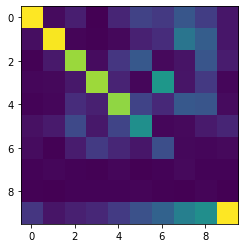

In [10]:
# print(test_acc_per_class(amtfl_params, sess_amtfl, x_tst, y_tst))
trans_mat = tf.abs(tf.matmul(amtfl_params['A'], amtfl_params['S'])).eval(session=sess_amtfl)

plt.imshow(trans_mat)